In [27]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings


# Ignore warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [32]:
file_path = '/workspaces/ML_ZOOMCAMP_2024/bank-full.csv'
df = pd.read_csv(file_path, sep=';')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [33]:
df = df[["age","job", "marital", "education", "balance",
         "housing", "contact", "day", "month", "duration",
         "campaign", "pdays", "previous", "poutcome", "y"]]

# Missing values
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [34]:
# Target variable
y = df['y']

# Feature variables
X = df.drop('y', axis=1)

# numerical columns
numerical_columns = ['age', 'balance', 'day', 'duration',
                     'campaign', 'pdays', 'previous']

# categorical columns
categorical_columns = ['job', 'marital', 'education', 'housing',
                       'contact', 'month', 'poutcome']

In [35]:
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['y'])


In [36]:
# Split the data into training (80%) and testing (20%) sets
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [37]:
# Split the data into training (60%)) and testing (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=42)


In [38]:
# Feature variables shape
print(X_train.shape, X_test.shape, X_val.shape)

# Target variable shape
print(y_train.shape, y_test.shape, y_val.shape)

(27126, 14) (9043, 14) (9042, 14)
(27126,) (9043,) (9042,)



## Question 1: ROC AUC feature importance

In [39]:
from sklearn.metrics import roc_auc_score

auc_scores = {}

for feature in numerical_columns:
    auc = roc_auc_score(y_train, X_train[feature])
    # If AUC is less than 0.5, invert the feature
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[feature])
    auc_scores[feature] = auc

# Find the feature with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
best_auc = auc_scores[best_feature]

print(f"The feature with the highest AUC is {best_feature} with an AUC of {best_auc}.")


The feature with the highest AUC is duration with an AUC of 0.8087539479327678.


## Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

*LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)*
- > What's the AUC of this model on the validation dataset? (round to 3 digits)

In [40]:
from sklearn.feature_extraction import DictVectorizer

# One-hot encoding for categorical columns
dv = DictVectorizer(sparse=False)

train_dict = X_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = X_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = X_test[categorical_columns + numerical_columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [41]:
from sklearn.linear_model import LogisticRegression


# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_proba = model.predict_proba(X_val)[:, 1]  # Get probability for the positive class

# Compute AUC on the validation set
auc = roc_auc_score(y_val, y_val_pred_proba)

# Print the AUC rounded to 3 digits
print(f"The AUC of the model on the validation dataset is {auc:.3f}.")


The AUC of the model on the validation dataset is 0.910.


## Question 3: Precision and Recall
- > At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

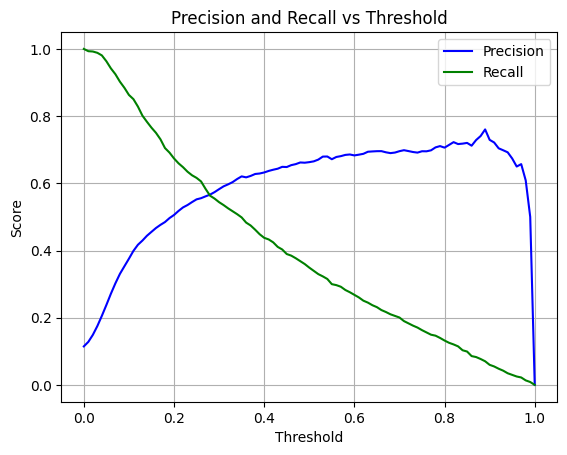

Precision and recall curves intersect at threshold: 0.28


In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)  # Thresholds from 0.0 to 1.0 with step 0.01
precisions = []
recalls = []

# Loop over thresholds and compute precision and recall
for threshold in thresholds:
    # Predict labels based on threshold
    y_pred = (y_val_pred_proba >= threshold).astype(int)
    
    # Compute precision and recall
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold where precision and recall intersect
for i in range(len(thresholds)):
    if np.isclose(precisions[i], recalls[i], atol=0.01):  # Check if values are close within tolerance
        intersection_threshold = thresholds[i]
        print(f"Precision and recall curves intersect at threshold: {intersection_threshold:.2f}")
        break

## Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

- > At which threshold F1 is maximal?


In [43]:
thresholds = np.arange(0.0, 1.0, 0.01)  # Thresholds from 0.0 to 1.0 with step 0.01
f1_scores = []

# Loop over thresholds and compute F1 score
for threshold in thresholds:
    # Predict labels based on threshold
    y_pred = (y_val_pred_proba >= threshold).astype(int)
    
    # Compute precision and recall
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    # Compute F1 score
    if precision + recall > 0:  # Avoid division by zero
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_scores.append(f1)

# Find the threshold where F1 score is maximal
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]
max_f1_score = f1_scores[max_f1_index]

print(f"The threshold with the highest F1 score is {best_threshold:.2f} with an F1 score of {max_f1_score:.3f}.")


The threshold with the highest F1 score is 0.25 with an F1 score of 0.582.


## Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

*KFold(n_splits=5, shuffle=True, random_state=1)*

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation
- > How large is standard deviation of the scores across different folds?

In [44]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)
dv = DictVectorizer(sparse=False)  # To handle categorical variables

auc_scores = []

# Iterate over the KFold splits
for train_idx, val_idx in kf.split(X_full_train):
    # Split the data into train and validation sets
    X_train, X_val = X_full_train.iloc[train_idx], X_full_train.iloc[val_idx]
    y_train, y_val = y_full_train[train_idx], y_full_train[val_idx]  # NumPy indexing
    
    # Convert training and validation data to dictionary format and apply one-hot encoding
    X_train_dict = X_train.to_dict(orient='records')
    X_val_dict = X_val.to_dict(orient='records')
    
    X_train_encoded = dv.fit_transform(X_train_dict)
    X_val_encoded = dv.transform(X_val_dict)
    
    # Train the logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)
    
    # Predict probabilities for the validation set
    y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]  # Get probability for the positive class
    
    # Compute the AUC for the validation fold
    auc = roc_auc_score(y_val, y_val_pred_proba)
    auc_scores.append(auc)

# Calculate the standard deviation of AUC scores across folds
auc_std_dev = np.std(auc_scores)

print(f"AUC scores for each fold: {auc_scores}")
print(f"Standard deviation of AUC scores: {auc_std_dev:.3f}")


AUC scores for each fold: [np.float64(0.8993556310932126), np.float64(0.8993206548548723), np.float64(0.9112583997605899), np.float64(0.9081048228522398), np.float64(0.9120491718502978)]
Standard deviation of AUC scores: 0.006


## Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: *[0.000001, 0.001, 1]*
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: *LogisticRegression(solver='liblinear', C=C, max_iter=1000)*
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
- > Which C leads to the best mean score?

In [45]:
# Define the C values to iterate over
C_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=1)
dv = DictVectorizer(sparse=False)  # One-hot encoding for categorical features

# Initialize a dictionary to store the results
results = []

# Iterate over different C values
for C in C_values:
    auc_scores = []
    
    # Perform cross-validation
    for train_idx, val_idx in kf.split(X_full_train):
        # Split the data into train and validation sets
        X_train, X_val = X_full_train.iloc[train_idx], X_full_train.iloc[val_idx]
        y_train, y_val = y_full_train[train_idx], y_full_train[val_idx]
        
        # Convert to dictionary and apply DictVectorizer for encoding
        X_train_dict = X_train.to_dict(orient='records')
        X_val_dict = X_val.to_dict(orient='records')
        
        X_train_encoded = dv.fit_transform(X_train_dict)
        X_val_encoded = dv.transform(X_val_dict)
        
        # Train the logistic regression model with the given C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded, y_train)
        
        # Predict probabilities and calculate AUC
        y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred_proba)
        auc_scores.append(auc)
    
    # Calculate the mean and standard deviation of AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store the results
    results.append({
        'C': C,
        'mean_auc': round(mean_auc, 3),
        'std_auc': round(std_auc, 3)
    })

# Sort the results to find the best C (prefer lower std and smaller C if tied)
results_sorted = sorted(results, key=lambda x: (x['mean_auc'], -x['std_auc'], -x['C']), reverse=True)

# Display the results
for result in results_sorted:
    print(f"C={result['C']}, Mean AUC={result['mean_auc']}, Std AUC={result['std_auc']}")

# Find the best C value
best_result = results_sorted[0]
print(f"\nBest C value is {best_result['C']} with mean AUC={best_result['mean_auc']} and Std AUC={best_result['std_auc']}")


C=1, Mean AUC=0.906, Std AUC=0.006
C=0.001, Mean AUC=0.861, Std AUC=0.007
C=1e-06, Mean AUC=0.701, Std AUC=0.009

Best C value is 1 with mean AUC=0.906 and Std AUC=0.006
